<a href="https://colab.research.google.com/github/mtablado/uoc2022_tfm/blob/main/vq-vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://learnopencv.com/variational-autoencoder-in-tensorflow/

https://keras.io/examples/generative/vae/

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers                                                                                                                                                                                                                                                                                                                                       
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
import numpy as np
import math                                                                                                                 

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

PIXELS = 128

In [3]:
from google.colab import drive
# Force the mount due to several errors with drive sync
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


In [5]:
def get_encoder(latent_dim=16):
  encoder_inputs = keras.Input(shape=(PIXELS, PIXELS, 1))

  # Block-0
  x = layers.Conv2D(32, kernel_size=4, strides=2, padding='same', name='conv_0')(encoder_inputs)
  x = layers.BatchNormalization(name='bn_0')(x)
  x = layers.LeakyReLU(name='lrelu_0')(x)
  #x = layers.MaxPooling2D((2, 2), padding='same')(x)

  # Block-1
  x = layers.Conv2D(32, kernel_size=4, strides=2, padding='same', name='conv_1')(x)
  x = layers.BatchNormalization(name='bn_1')(x)
  x = layers.LeakyReLU(name='lrelu_1')(x)
  #x = layers.MaxPooling2D((2, 2), padding='same')(x)

  # Block-2
  x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same', name='conv_2')(x)
  x = layers.BatchNormalization(name='bn_2')(x)
  x = layers.LeakyReLU(name='lrelu_2')(x)
  #x = layers.MaxPooling2D((2, 2), padding='same')(x)

  # Block-3
  x = layers.Conv2D(64, 4, 2, padding='same', name='conv_3')(x)
  x = layers.BatchNormalization(name='bn_3')(x)
  x = layers.LeakyReLU(name='lrelu_3')(x)
  #x = layers.MaxPooling2D((2, 2), padding='same')(x)

  # Block-4
  x = layers.Conv2D(64, 4, 2, padding='same', name='conv_4')(x)
  x = layers.BatchNormalization(name='bn_4')(x)
  x = layers.LeakyReLU(name='lrelu_4')(x)
  #x = layers.MaxPooling2D((2, 2), padding='same')(x)

  # Block-5
  x = layers.Conv2D(64, 4, 2, padding='same', name='conv_5')(x)
  x = layers.BatchNormalization(name='bn_5')(x)
  x = layers.LeakyReLU(name='lrelu_5')(x)
  #x = layers.MaxPooling2D((2, 2), padding='same')(x)

  encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
  model = keras.Model(encoder_inputs, encoder_outputs, name="encoder")
  model.summary()
  return model

In [6]:
def get_decoder(latent_dim=16):
  latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])

  # Block-1
  x = layers.Conv2DTranspose(64, 4, strides= 2, padding='same',name='conv_transpose_1')(latent_inputs)
  x = layers.BatchNormalization(name='bn_1')(x)
  x = layers.LeakyReLU(name='lrelu_1')(x)
  #x = layers.UpSampling2D((2, 2))(x)

  # Block-2
  x = layers.Conv2DTranspose(64, 4, strides= 2, padding='same', name='conv_transpose_2')(x)
  x = layers.BatchNormalization(name='bn_2')(x)
  x = layers.LeakyReLU(name='lrelu_2')(x)
  #x = layers.UpSampling2D((2, 2))(x)

  # Block-3
  x = layers.Conv2DTranspose(64, 4, 2, padding='same', name='conv_transpose_3')(x)
  x = layers.BatchNormalization(name='bn_3')(x)
  x = layers.LeakyReLU(name='lrelu_3')(x)
  #x = layers.UpSampling2D((2, 2))(x)

  # Block-4
  x = layers.Conv2DTranspose(32, 4, 2, padding='same', name='conv_transpose_4')(x)
  x = layers.BatchNormalization(name='bn_4')(x)
  x = layers.LeakyReLU(name='lrelu_4')(x)
  #x = layers.UpSampling2D((2, 2))(x)

  # Block-4
  x = layers.Conv2DTranspose(1, 4, 2, padding='same', name='conv_transpose_5')(x)
  x = layers.BatchNormalization(name='bn_5')(x)
  x = layers.LeakyReLU(name='lrelu_5')(x)
  #x = layers.UpSampling2D((2, 2))(x)

  # Block-6
  decoder_outputs = layers.Conv2DTranspose(1, 4, 2,padding='same', activation='sigmoid', name='conv_transpose_6')(x)
  model = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
  model.summary()
  return model

In [7]:
def get_vqvae(latent_dim=16, num_embeddings=64):
  vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
  encoder = get_encoder(latent_dim)
  decoder = get_decoder(latent_dim)
  inputs = keras.Input(shape=(PIXELS, PIXELS, 1))
  encoder_outputs = encoder(inputs)
  quantized_latents = vq_layer(encoder_outputs)
  reconstructions = decoder(quantized_latents)
  return keras.Model(inputs, reconstructions, name="vq_vae")

vqvae = get_vqvae()
vqvae.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv_0 (Conv2D)             (None, 64, 64, 32)        544       
                                                                 
 bn_0 (BatchNormalization)   (None, 64, 64, 32)        128       
                                                                 
 lrelu_0 (LeakyReLU)         (None, 64, 64, 32)        0         
                                                                 
 conv_1 (Conv2D)             (None, 32, 32, 32)        16416     
                                                                 
 bn_1 (BatchNormalization)   (None, 32, 32, 32)        128       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 32, 32, 32)        0   

In [8]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


Images stored with *matplotlib.imsave* are not normalized, so we will rescale the pixels while reading

https://medium.com/analytics-vidhya/understanding-image-augmentation-using-keras-tensorflow-a6341669d9ca

In [9]:
import numpy as np
import cv2
path_to_file="/content/drive/My Drive/tfm/dataset/slices/training/t1/IXI002-Guys-0828-T1_0.png"
img=cv2.imread(path_to_file,0)# read in image as grayscale
max_pixel_value=np.max(img) #  find maximum pixel value
min_pixel_value=np.min(img) # find minimum pixel value
print('max pixel value= ', max_pixel_value, '  min pixel value= ', min_pixel_value)

max pixel value=  255   min pixel value=  0


In [10]:
%cd /content/drive/My Drive/tfm/dataset/slices-160-190
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./(PIXELS - 1) # To normalize values
    )

train_generator = train_datagen.flow_from_directory(
        'training',
        target_size=(PIXELS, PIXELS),
        batch_size=64, # Number of images processed together
        color_mode='grayscale',
        class_mode=None)

test_datagen = ImageDataGenerator(rescale=1./(PIXELS - 1))

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(PIXELS, PIXELS),
        batch_size=64,
        color_mode='grayscale',
        class_mode=None)

/content/drive/.shortcut-targets-by-id/1yKlrvb9Cp3amASiDUettfP3V1KJuzGDe/tfm/dataset/slices-160-190
Found 16268 images belonging to 1 classes.
Found 1162 images belonging to 1 classes.


In [11]:
def calculate_data_variance(generator :ImageDataGenerator):
  DATA_VARIANCE = 0.09493041879725218 # Change to zero for computing

  if DATA_VARIANCE > 0:
    data_variance = DATA_VARIANCE
    print("Default Data variance " + str(data_variance))
  else:
    batches = test_generator.next()
    for batch in test_generator:
      batch = test_generator.next()
      print(batch.shape)
      data_variance = np.var(batch / PIXELS)
      print("Computed Data variance " + str(data_variance))

  return data_variance

data_variance = calculate_data_variance(test_generator)

Default Data variance 0.09493041879725218


In [12]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

print(x_train.shape)
x_train = np.expand_dims(x_train, -1)
print(x_train.shape)

x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / PIXELS) - 0.5
x_test_scaled = (x_test / PIXELS) - 0.5

data_variance = np.var(x_train / PIXELS)
print(data_variance)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)
0.3767608936945399


In [13]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv_0 (Conv2D)             (None, 64, 64, 32)        544       
                                                                 
 bn_0 (BatchNormalization)   (None, 64, 64, 32)        128       
                                                                 
 lrelu_0 (LeakyReLU)         (None, 64, 64, 32)        0         
                                                                 
 conv_1 (Conv2D)             (None, 32, 32, 32)        16416     
                                                                 
 bn_1 (BatchNormalization)   (None, 32, 32, 32)        128       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 32, 32, 32)        0   

In [14]:
EPOCHS = 200
mfit = vqvae_trainer.fit(train_generator, epochs=EPOCHS, batch_size=64)

Epoch 1/200
255/255 [==============================] - 230s 812ms/step - loss: 0.5326 - reconstruction_loss: 0.3045 - vqvae_loss: 0.0925
Epoch 2/200
255/255 [==============================] - 46s 181ms/step - loss: 0.2161 - reconstruction_loss: 0.1607 - vqvae_loss: 0.0473
Epoch 3/200
255/255 [==============================] - 46s 182ms/step - loss: 0.1811 - reconstruction_loss: 0.1363 - vqvae_loss: 0.0403
Epoch 4/200
255/255 [==============================] - 46s 181ms/step - loss: 0.1713 - reconstruction_loss: 0.1249 - vqvae_loss: 0.0447
Epoch 5/200
255/255 [==============================] - 46s 180ms/step - loss: 0.1659 - reconstruction_loss: 0.1174 - vqvae_loss: 0.0473
Epoch 6/200
255/255 [==============================] - 46s 181ms/step - loss: 0.1598 - reconstruction_loss: 0.1128 - vqvae_loss: 0.0460
Epoch 7/200
255/255 [==============================] - 48s 189ms/step - loss: 0.1551 - reconstruction_loss: 0.1095 - vqvae_loss: 0.0450
Epoch 8/200
255/255 [==========================

In [15]:
trained_vqvae_model = vqvae_trainer.vqvae

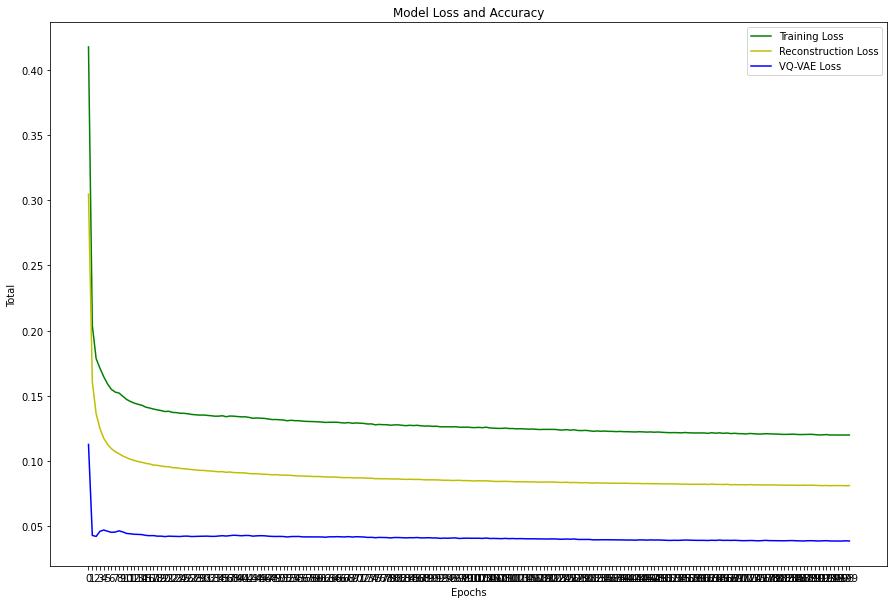

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

# Plot del training loss y el accuracy
def plot_loss(n_epochs, mfit):
  loss = mfit.history['loss']
  rec_loss = mfit.history['reconstruction_loss']
  vqvae_loss = mfit.history['vqvae_loss']
  
  epochs = range(0,n_epochs)
  plt.subplots(figsize=(15,10))
  plt.plot(epochs, loss, 'g', label='Training Loss')
  plt.plot(epochs, rec_loss, 'y', label='Reconstruction Loss')
  plt.plot(epochs, vqvae_loss, 'b', label='VQ-VAE Loss')

  plt.title('Model Loss and Accuracy')
  plt.xticks(epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Total')
  plt.legend()
  plt.show()

plot_loss(EPOCHS, mfit)

In [17]:
trained_vqvae_model = vqvae_trainer.vqvae
y_pred = trained_vqvae_model.predict(test_generator)

19/19 [==============================] - 214s 12s/step


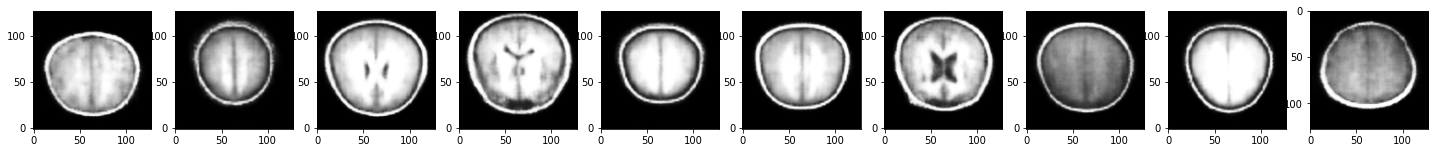

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

number_of_images = 10 #len(y_pred)
fig, axes = plt.subplots(1, number_of_images, figsize=(25,25))

# Show some images
for i in range(len([0,1,2,3,4,5,6,7,8,9])):
  image = y_pred[i]
  image = image[:,:,0]
  axes[i].imshow(image, cmap="gray", origin="lower")
  # Display the first image in training data
  #img = image[:,:,100]
  plt.imshow(image, cmap='gray')

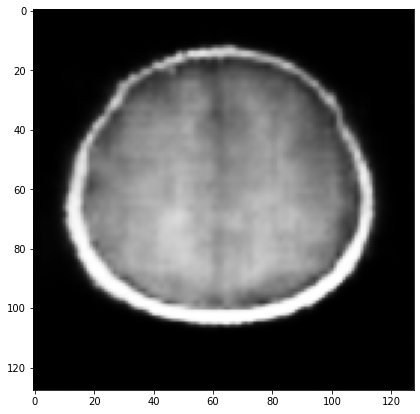

In [19]:
plt.figure(figsize=[15,15])

# Display the first image in training data
plt.subplot(121)
plt.imshow(image, cmap='gray')